## Chromaticity Spaces and Illuminate Spectral Ratio  
This notebook implements various aspects of Maxwell's RoadVision Paper

___ 
### Packages

In [187]:
import cv2  
import pandas as pd  
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path

___
### Set Up Paths

In [188]:
HOME = Path.cwd()
PATH_TO_DATA_FOLDER = HOME / "data" / "folder_8" / "done"
PATH_TO_ANNOTATIONS_CSV =  HOME / "data" / "folder_8"
img_file =  "wenqing_fan_065.tif" #"wenqing_fan_0101.tif" # "walsh_john_035.tif" 
annotations_csv_file = "annotation_folder_8.csv"
epsilon = 1e-10 # to be used to avoid dividing by zero
equalize_hist = False # This will apply histogram equalization to log chroma imgs
normalize_img = False

___ 
### Read In Test Image

In [189]:
img = cv2.imread(str(PATH_TO_DATA_FOLDER) + "/" + img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if normalize_img:
    img = img / 255.0

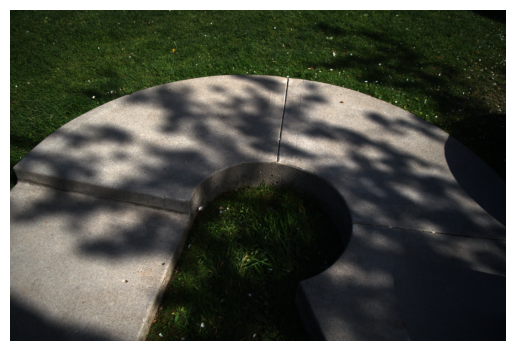

In [190]:
plt.imshow(img)
plt.axis("off");

In [191]:
img.dtype

dtype('uint8')

___
### Convert ```img``` to Standard Chromaticity Space

$$ (\hat{r}, \hat{g}) = \bigg(\frac{R}{(R + G + B)}, \frac{G}{(R + G + B)}\bigg) $$

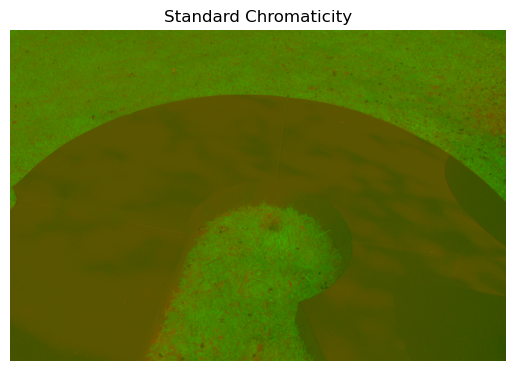

In [192]:
def convert_img_to_rg_chromaticity(img:np.array, epsilon:float = 1e-10) -> np.array:
    """  
    Generates rg chromaticity image from a RGB image
    """
    # Compute the sum of pixels
    rbg_sum = img.sum(axis = 2, keepdims = True)

    # Divide each channel by pixel sum
    standard_chromaticity = img / (rbg_sum + epsilon)

    # Extract the r and g channels
    r_channel = standard_chromaticity[:, :, 0]
    g_channel = standard_chromaticity[:, :, 1]

    # Add a blue channel of zeros
    chromaticity_image = np.stack((r_channel, g_channel, np.zeros_like(r_channel)), axis = 2)
    
    return chromaticity_image

def display_image(chromaticity_image:np.array, title:str) -> None:
    """ 
    Displays an image using mayplotlib
    """
    plt.imshow(chromaticity_image)
    plt.title(title)
    plt.axis('off')
    plt.show();


chromaticity_image = convert_img_to_rg_chromaticity(img)
display_image(chromaticity_image, "Standard Chromaticity")

___
### Convert ```img``` to Log Chromaticity Space

$$ \log(\hat{r}, \hat{g}) = \bigg[\log\bigg(\frac{R}{(R + G + B)}\bigg), \log\bigg(\frac{G}{(R + G + B)}\bigg)\bigg]$$

$$ \log(\hat{r}, \hat{g}) = \bigg[\bigg(\log(R) - \log(R + G + B)\bigg), \bigg(\log(G) - \log(R + G + B)\bigg)\bigg]$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44729890968712477..1.1435462118070987].


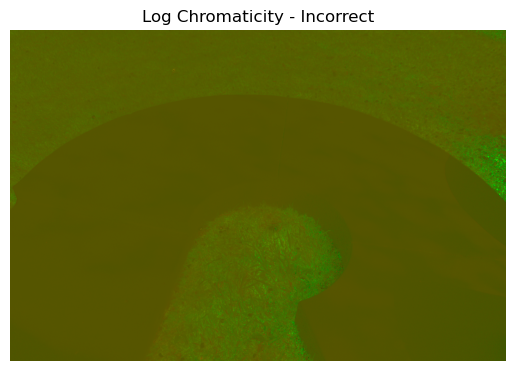

In [193]:
# This I do not think is correct, it just computes chromaticity after projecting img to log space
log_img = np.log(img + epsilon)
log_chroma = convert_img_to_rg_chromaticity(log_img)
display_image(log_chroma, "Log Chromaticity - Incorrect")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.314024539275692..9.586566796191741].


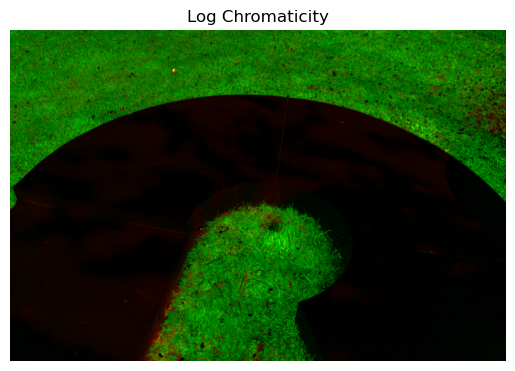

In [194]:
def convert_img_to_log_rg_chromaticity(img:np.array, epsilon:float = 1e-10, equalize_hist:bool = False) -> np.array:
    """  
    Generates log_rg chromaticity image from a RGB image
    Uses the the mean of the 3 pixel channels.
    """
    # Compute the log of the img
    log_rgb = np.log(img + epsilon) # Epsilon to avoid taking the log of zero

    # Compute log chromaticity of each channel, use mean rather sum to normalize
    # If you change this to exactly replicate the above equation you end up with a black image.
    # If you then histEqual, you end up with essentially the exact same image as produced here using np.mean (as below)
    log_chromaticity = log_rgb - log_rgb.mean(axis = 2, keepdims = True)  # Division becomes subtraction in log space

    # Extract the r and g channels
    log_r = log_chromaticity[:, :, 0]
    log_g = log_chromaticity[:, :, 1]

    if equalize_hist:
        
        # Rescale log_r and log_g to the range [0, 255] for equalization
        log_r_rescaled = ((log_r - log_r.min()) / (log_r.max() - log_r.min()) * 255).astype(np.uint8)
        log_g_rescaled = ((log_g - log_g.min()) / (log_g.max() - log_g.min()) * 255).astype(np.uint8)

        # Apply histogram equalization
        log_r_equalized = cv2.equalizeHist(log_r_rescaled)
        log_g_equalized = cv2.equalizeHist(log_g_rescaled)

        # Normalize equalized values back to [0, 1]
        log_r = log_r_equalized / 255.0
        log_g = log_g_equalized / 255.0

    # Create rg image
    log_chromaticity_image = np.stack((log_r, log_g, np.zeros_like(log_r)), axis = 2)

    return log_chromaticity_image

log_chromaticity_image = convert_img_to_log_rg_chromaticity(img, epsilon, equalize_hist = False)
display_image(log_chromaticity_image, "Log Chromaticity")


___
### Estimate Illuminate Spectral Direction  
This requires lit and shadow pixels

___ 
### Read In CSV of Lit & Shadowed Pixels

In [195]:
annotations_df = pd.read_csv(str(PATH_TO_ANNOTATIONS_CSV) + "/" + annotations_csv_file, index_col = "filename")
annotations_df.head()


,lit_row1,lit_col1,shad_row1,shad_col1,lit_row2,lit_col2,shad_row2,shad_col2,lit_row3,lit_col3,...,shad_row4,shad_col4,lit_row5,lit_col5,shad_row5,shad_col5,lit_row6,lit_col6,shad_row6,shad_col6
filename,,,,,,,,,,,,,,,,,,,,,
walsh_john_001.tif,682,395,649,485,693,433,664,513,737,461,...,683,709,732,710,688,759,702,338,659,429
walsh_john_015.tif,788,317,764,385,291,166,282,230,348,168,...,695,330,898,413,879,451,446,814,438,881
wenqing_fan_010.tif,670,156,684,235,709,142,745,195,754,112,...,741,668,650,580,650,675,477,635,481,748
wenqing_fan_004.tif,927,861,802,789,920,998,808,838,363,916,...,395,959,365,1036,407,1004,155,894,221,606
wenqing_fan_038.tif,692,400,599,404,708,463,570,465,724,537,...,557,648,741,346,765,191,689,611,635,619


### Get Pixel Coordinates  
This will extract the lit and shadow pixel coordinates from the annotations csv

In [196]:
def get_lit_shadow_pixel_coordinates(annotations_df:pd.DataFrame, image_file_name:str) -> tuple:
    """  
    Extracts the lit and shadow pixel locations from the annoations df.
    Note: filename has to be set as the index for annotation df
    """
    # Extract annotations for image of interest
    image_annotations = annotations_df.loc[image_file_name]

    # Extract lit and shadow pixels
    lit_pixels = [
        (image_annotations[f"lit_row{i}"], image_annotations[f"lit_col{i}"])
        for i in range(1, 7)
    ]
    shadow_pixels = [
        (image_annotations[f"shad_row{i}"], image_annotations[f"shad_col{i}"])
        for i in range(1, 7)
    ]
    return lit_pixels, shadow_pixels

lit_pixels, shadow_pixels = get_lit_shadow_pixel_coordinates(annotations_df, img_file)

print(f"Lit pixels: {lit_pixels}")
print(f"Shadow Pixels: {shadow_pixels}")


Lit pixels: [(849, 293), (809, 358), (331, 383), (309, 1040), (335, 1056), (847, 251)]
Shadow Pixels: [(739, 299), (721, 409), (287, 507), (339, 1133), (381, 958), (745, 324)]


### Inspect the Annotations

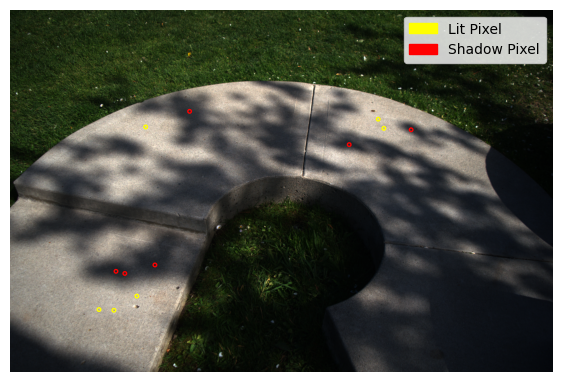

In [197]:
def inspect_annotations(img:np.array, lit_pixels:list, shadow_pixels:list) -> None:
    """  
    Displays the image with lit and shadow pixels highlighted
    """
    fig, ax = plt.subplots(figsize = (7, 12))
    ax.imshow(img)

    # Add circles around lit pixels
    for (y, x) in lit_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='yellow', facecolor='none', linewidth=1, label='Lit Pixel')
        ax.add_patch(circle)

    # Add circles arond the shadow pixels
    for (y, x) in shadow_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', linewidth=1, label='Shadow Pixel')
        ax.add_patch(circle)

    # Add the legend
    handles = [
        patches.Patch(color='yellow', label='Lit Pixel'),
        patches.Patch(color='red', label='Shadow Pixel')
    ]
    plt.legend(handles = handles)
    plt.axis('off')
    plt.show()

inspect_annotations(img, lit_pixels, shadow_pixels)


In [198]:
print(lit_pixels)
print(shadow_pixels)

[(849, 293), (809, 358), (331, 383), (309, 1040), (335, 1056), (847, 251)]
[(739, 299), (721, 409), (287, 507), (339, 1133), (381, 958), (745, 324)]


### Compute the ISD  
This is from 4.1 of Lightbrush:  

4.1 Base Constraints and Linear System Representation
4.1.1 Illumination Spectral Direction. The only required user input
is an estimate of the illumination spectral direction. The ISD
defines the log chromaticity space for the log-chromaticity clustering
step. While automated schemes for detecting the ISD are
possible, we opt to allow simple user control. Lightbrush includes a
lit-dark pair tool that consists of two linked squares (Figure 4(a)).
The user places one square in a lit area of a material and the other
square in a shadowed area of the same material. The system uses
the average value under each block to estimate the ISD. If the user
specifies multiple lit-dark pairs, they can tell Lightbrush to average
the estimated ISDs or use a local adaptation scheme to deal with
changing illumination conditions within the scene.

In [199]:
# Covert Image to log space
log_rgb = np.log(img + epsilon)

# Compute the isd for each lit-shadow pair
isd_list = []

# Iterate over the pairs
for (lit_pix, shadow_pix) in zip(lit_pixels, shadow_pixels):

    # Get the pixel values
    lit_pixel = log_rgb[lit_pix[0], lit_pix[1]]
    shadow_pixel = log_rgb[shadow_pix[0], shadow_pix[1]]

    # Compute and store the ISD
    isd = lit_pixel - shadow_pixel
    isd = isd / np.linalg.norm(isd)
    isd_list.append(isd)

print(f"Illuminate Spectral Direction for Each Pair:")
for isd in isd_list:
    print(f"\t{isd}")

# Compute the mean ISD, Bruce mentions this in LightBrush
mean_isd = np.mean(np.array(isd_list), axis = 0)
print()
print(f"Mean ISD:\n\t {mean_isd}")

Illuminate Spectral Direction for Each Pair:
	[0.68018429 0.57510869 0.45453198]
	[0.62062777 0.58717046 0.5196653 ]
	[0.62475002 0.59770835 0.50242625]
	[0.62030623 0.59686478 0.50889353]
	[0.66365254 0.57231058 0.48169067]
	[0.62717597 0.58176268 0.5178827 ]

Mean ISD:
	 [0.63944947 0.58515426 0.49751507]


### Inspect ISD

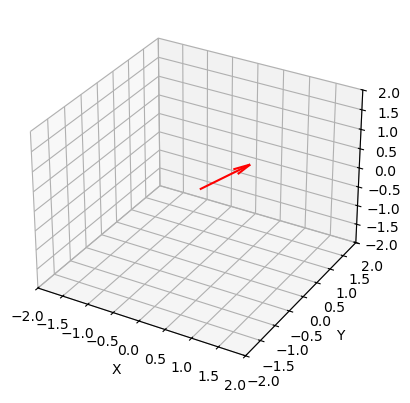

In [200]:
def plot_isd_vector_3D(mean_isd:np.array) -> None:
    """  
    Displays the mean ISD vector
    """
    # Set up 3D fig
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the ISD vector - This is through the origin, idk for sure about this
    ax.quiver(0, 0, 0, mean_isd[0], mean_isd[1], mean_isd[2], color='r', arrow_length_ratio=0.3)

    # Set limits for the axes
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z');

plot_isd_vector_3D(mean_isd)

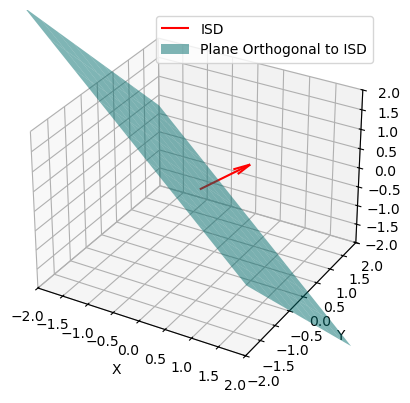

In [201]:
def plot_plane_orthogonal_to_isd(mean_isd:np.array, img:np.array = None) -> None:
    """
    Displays the plane orthogonal to the ISD vector.
    Can also display projected points
    """
    # Set up the figure and 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vector using mean_isd
    ax.quiver(0, 0, 0, mean_isd[0], mean_isd[1], mean_isd[2], color='r', arrow_length_ratio=0.3, label = "ISD")

    # Create a grid for the plane centered at the origin, again not sure about the origin
    # But it needs to be anchored somewhere, no?
    xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))

    # Compute the corresponding z values for the plane
    # Plane equation: mean_isd[0]*x + mean_isd[1]*y + mean_isd[2]*z = 0
    # Solve for z: z = -(mean_isd[0]*x + mean_isd[1]*y) / mean_isd[2]
    zz = -(mean_isd[0] * xx + mean_isd[1] * yy) / mean_isd[2]

    # Plot the plane
    ax.plot_surface(xx, yy, zz, alpha=0.5, color='cyan', label = "Plane Orthogonal to ISD")

    # Add the image points
    if img is not None:

        # Plot the projected points
        ax.scatter(img[:, :, 0], img[:, :, 1], img[:, :, 2], color='b', alpha=0.1, s=1, label='Projected Points')

    # Set the limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

plot_plane_orthogonal_to_isd(mean_isd)

### Project Log RGB onto ISD  
$$projection = \vec{ISD} \cdot IMG_{log}$$  

This produces a scalar value for each pixel representing how much of the pixel intensity is along the ISD

In [202]:
projection = np.dot(log_rgb, isd)

# Print the shape to verify
print(f"Projection shape: {projection.shape}")
print(f"Projection example: {projection.ravel()[:5]}")

Projection shape: (1024, 1533)
Projection example: [4.85764737 5.1741911  4.88865858 4.38761733 4.82578971]


### Generate Projection Matrix

In [203]:
# Get the dims of the image
H, W, _ = log_rgb.shape

# Container for projection vector that matches image dims
projection_matrix = np.zeros((H, W, 3))

# Multiply the scalar projection with each channel of the ISD vector
for i in range(3):  # Channels (R, G, B)
    for x in range(H):  # Height
        for y in range(W):  # Width

            # Multiply the scalar projection by the i-th ISD component
            projection_matrix[x, y, i] = projection[x, y] * isd[i]

# Display results
print(f"Projection vector shape: {projection_matrix.shape}")
print(f"Projection vector example (first pixel): {projection_matrix[0, 0]}")


Projection vector shape: (1024, 1533, 3)
Projection vector example (first pixel): [3.0465997  2.82599794 2.51569153]


### Subtract Projection Matrix

In [204]:
projected_log_rgb = log_rgb - projection_matrix

### Inspect Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20.21685669562363..9.318492370702671].


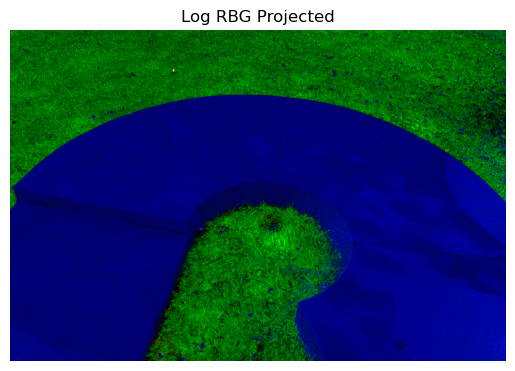

In [205]:
display_image(projected_log_rgb, "Log RBG Projected")

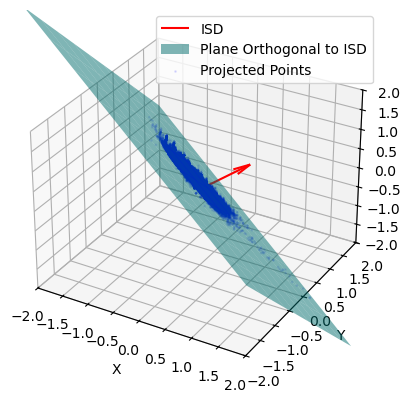

In [206]:
plot_plane_orthogonal_to_isd(mean_isd, projected_log_rgb)

### Compute Log Chromoaticity on ```log_rgb_prjected```  

The steps above do not actually end up with a chromaticity space.  
So I tried to do it here right as I was leaving.  
THIS DOES NOT WORK

In [207]:
# Does not currently work
log_rbg_projected_chroma = convert_img_to_log_rg_chromaticity(projected_log_rgb, True)

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_76730/778529907.py:7: RuntimeWarning: invalid value encountered in log
  log_rgb = np.log(img + epsilon) # Epsilon to avoid taking the log of zero


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.051550373818949..2.690121218125361].


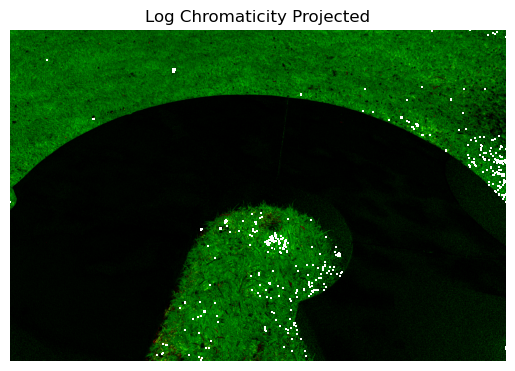

In [208]:
display_image(log_rbg_projected_chroma, "Log Chromaticity Projected")

___
### This is the other way to do it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.62486248234787..9.535680484346074].


Lit Values: [[5.25749537 5.09986643 4.89034913]
 [5.26785816 5.23110862 5.14749448]
 [5.31320598 5.24702407 5.14166356]
 [5.26785816 5.28320373 5.20948615]
 [5.23644196 5.18738581 5.11198779]
 [5.22035583 5.18178355 5.13579844]]
Shadow Values: [[3.49650756 3.61091791 3.71357207]
 [3.55534806 3.61091791 3.71357207]
 [3.78418963 3.78418963 3.91202301]
 [3.61091791 3.68887945 3.8501476 ]
 [3.55534806 3.73766962 3.8918203 ]
 [3.68887945 3.76120012 3.87120101]]
Lit value - shawdow values: [[1.76098781 1.48894852 1.17677706]
 [1.7125101  1.6201907  1.43392241]
 [1.52901635 1.46283444 1.22964055]
 [1.65694025 1.59432427 1.35933855]
 [1.6810939  1.44971619 1.22016749]
 [1.53147637 1.42058343 1.26459743]]
Mean Lit [5.26053591 5.20506203 5.10612992]


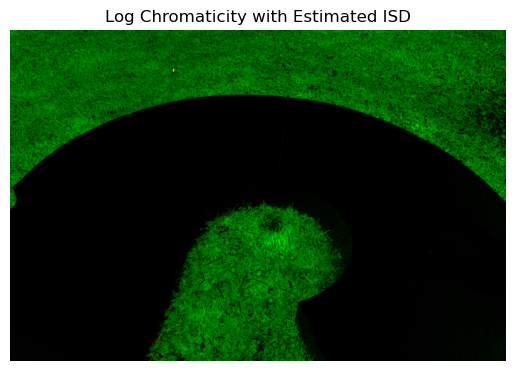

In [209]:
# Covert Image to log space
log_rgb = np.log(img + epsilon)

# Unpack the tuples of pixel coordinates, i.e., create tuple of x's and tuple of y's
# Done to index using numpy
lit_x, lit_y = zip(*lit_pixels) 
shadow_x, shadow_y = zip(*shadow_pixels)

# Extract the lit and shadow pixel values
lit_values = log_rgb[lit_x, lit_y]
shadow_values = log_rgb[shadow_x, shadow_y]

print(f"Lit Values: {lit_values}")
print(f"Shadow Values: {shadow_values}")
print(f"Lit value - shawdow values: {lit_values - shadow_values}")

# Calculate the mean of the log rbg values for lit and shadow pixels
mean_lit = np.mean(lit_values, axis = 0)
print("Mean Lit", mean_lit)
mean_shadow = np.mean(shadow_values, axis = 0)

# Use equation #4 from Bruce's RoadVision Paper
isd = mean_lit - mean_shadow
isd = isd / np.linalg.norm(isd)

# Project out the ISD from the log RGB to create illumination invariant log chromaticity
projection = (log_rgb @ isd)[:, :, np.newaxis] * isd[np.newaxis, np.newaxis, :]
log_chromaticity = log_rgb - projection

# Extract r and g channels of the log chromaticity
log_r = log_chromaticity[:, :, 0]
log_g = log_chromaticity[:, :, 1]

if equalize_hist:
    
    # Rescale log_r and log_g to the range [0, 255] for equalization
    log_r_rescaled = ((log_r - log_r.min()) / (log_r.max() - log_r.min()) * 255).astype(np.uint8)
    log_g_rescaled = ((log_g - log_g.min()) / (log_g.max() - log_g.min()) * 255).astype(np.uint8)

    # Apply histogram equalization
    log_r_equalized = cv2.equalizeHist(log_r_rescaled)
    log_g_equalized = cv2.equalizeHist(log_g_rescaled)

    # Normalize equalized values back to [0, 1]
    log_r = log_r_equalized / 255.0
    log_g = log_g_equalized / 255.0

# Create a visualization for the log chromaticity (using r, g channels)
log_chromaticity_with_isd_image = np.stack((log_r, log_g, np.zeros_like(log_r)), axis=2)

# Display the log chromaticity image
plt.imshow(log_chromaticity_with_isd_image)
plt.title("Log Chromaticity with Estimated ISD")
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.314024539275692..9.586566796191741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.62486248234787..9.535680484346074].


Text(0.5, 1.0, 'ISD ~ Log Chromoaticity')

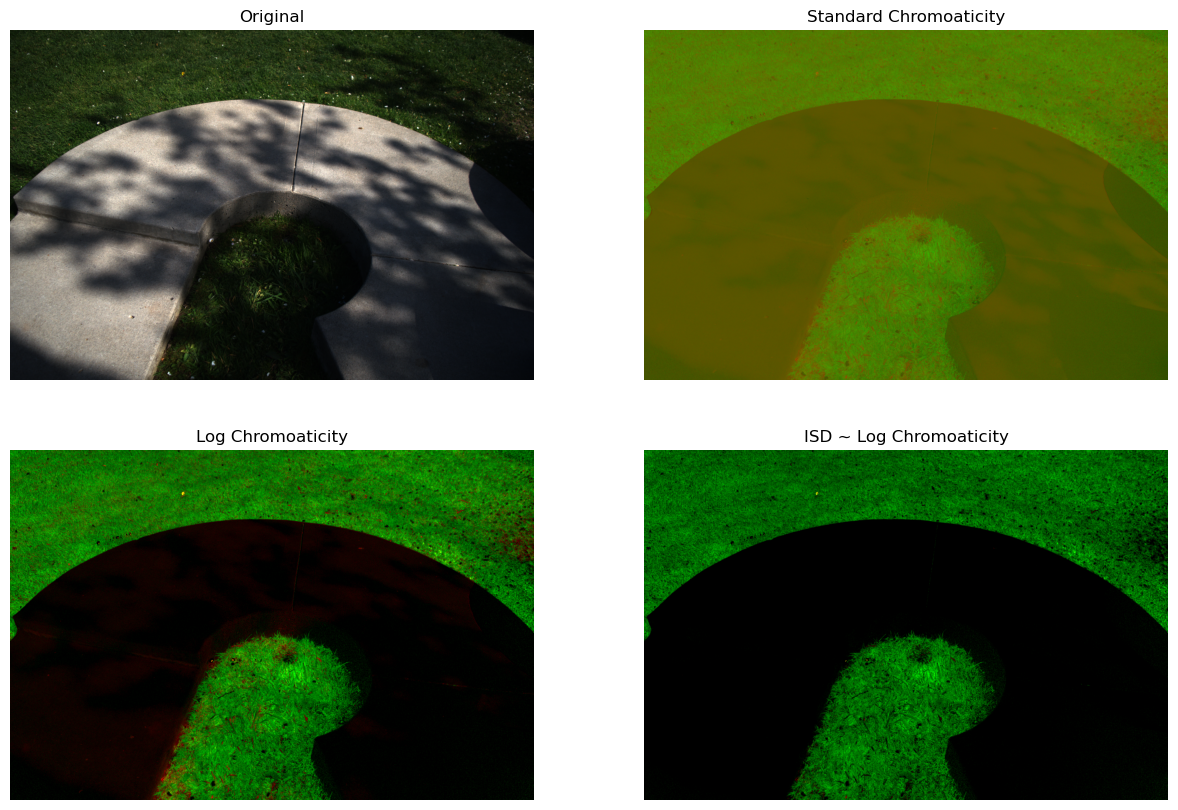

In [212]:
fig, axes = plt.subplots(2,2, figsize = (15, 10))
ax = axes.ravel()
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original")
ax[1].imshow(chromaticity_image)
ax[1].axis("off")
ax[1].set_title("Standard Chromoaticity")
ax[2].imshow(log_chromaticity_image)
ax[2].axis("off")
ax[2].set_title("Log Chromoaticity")
ax[3].imshow(log_chromaticity_with_isd_image)
ax[3].axis("off")
ax[3].set_title("ISD ~ Log Chromoaticity")